<a href="https://colab.research.google.com/github/KimJisanER/code_jjambbong/blob/main/%EC%A0%95%EB%A6%AC%EB%90%9C_aa_feature_to_pocket_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biopython
from Bio.PDB import PDBParser, Polypeptide
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import re
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
from Bio import BiopythonWarning
import tensorflow as tf
warnings.simplefilter('ignore', BiopythonWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.2 MB/s eta 0:00:00


In [ ]:
fasta_file = '/content/drive/MyDrive/5_HTR/accessions_sequence_0606_muscle.fasta'

def make_inverse_numbering_map(fasta_file, dataframe):
  with open(fasta_file, 'r') as f:
    lines = f.readlines()
  index = 0
  seqs = []
  headers = []
  header_positions = []  # Store the positions of headers satisfying the condition

  for i, line in enumerate(lines):
      if line.startswith('>'):
          headers.append(line.strip().upper())
          seqs.append('')
          if dataframe['target_accession'].max() in line:
              header_positions.append(index)  # Store the position of the header
          index += 1
      else:
          seqs[-1] += line.strip()

  seq = seqs[header_positions[0]]  # Get the sequence corresponding to the header position

  # Dictionary for positions without hyphen
  numbering_map = {}

  position_without_hyphen = 1
  position_with_hyphen = 1
  for aa in seq:
      if aa == '-':
          position_with_hyphen += 1
      else:
          numbering_map[position_without_hyphen] = position_with_hyphen
          position_without_hyphen += 1
          position_with_hyphen += 1



  return numbering_map

blosum62_matrix = {
    'A': [4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0, -2, -1, 0],
    'R': [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3, -1, 0, -1],
    'N': [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3, 3, 0, -1],
    'D': [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 4, 1, -1],
    'C': [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, -3, -3, -2],
    'Q': [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2, 0, 3, -1],
    'E': [-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2, 1, 4, -1],
    'G': [0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, -1, -2, -1],
    'H': [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0, 0, -1],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3, -3, -3, -1],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1, -4, -3, -1],
    'K': [-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2, 0, 1, -1],
    'M': [-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1, -3, -1, -1],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1, -3, -3, -1],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2, -2, -1, -2 ],
    'S': [1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2, 0, 0, 0],
    'T': [0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0, -1, -1, 0],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, -4, -3, -2],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1, -3, -2, -1],
    'V': [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4, -3, -2, -1],
    'B': [-2, -1, 3, 4, -3, 0, 1, -1, 0, -3, -4, 0, -3, -3, -2, 0, -1, -4, -3, -3, 4, 1, -1],
    'Z': [-1, 0, 0, 1, -3, 3, 4, -2, 0, -3, -3, 1, -1, -3, -1, 0, -1, -3, -2, -2, 1, 4, -1],
    'X': [0, -1, -1, -1, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -2, 0, 0, -2, -1, -1, -1, -1, -1],
    '-': [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4],
    '*': [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4]
}


def generate_aa_coords_array(pdb_name, input_list ,total_inverse_map):

  px = 128
  zoom = 2

  coords_list = []

  parser = PDBParser()
  structure = parser.get_structure("pdb_structure", f"/content/drive/MyDrive/3D/{pdb_name}.pdb")
  model = structure[0]

  for i in range(23):
      coords = tf.zeros((px, px, px), dtype=tf.float32)

      residue_list = [total_inverse_map.get(pdb_name.split('_')[1]).get(int(res),) for res in input_list]

      total_coords_x = []
      total_coords_y = []
      total_coords_z = []
      for chain in model:
          for residue in chain:
              if residue.get_id()[0] == " ":
                  res_id = residue.get_id()[1]
                  if res_id in residue_list:
                      atom = residue['CA']
                      coord = atom.get_coord()
                      total_coords_x.append(coord[0])
                      total_coords_y.append(coord[1])
                      total_coords_z.append(coord[2])

      center_x = tf.reduce_mean(total_coords_x)
      center_y = tf.reduce_mean(total_coords_y)
      center_z = tf.reduce_mean(total_coords_z)

      x_shift = px/2 - center_x
      y_shift = px/2 - center_y
      z_shift = px/2 - center_z

      model = structure[0]
      for chain in model:
          for residue in chain:
              if residue.get_id()[0] == " ":
                  res_id = residue.get_id()[1]
                  if res_id in residue_list:
                      try:
                          atom = residue['CA']
                          coord = atom.get_coord()
                          x, y, z = coord
                          x_index = tf.cast(tf.round((x + x_shift)*zoom) - px/2*(zoom-1), dtype=tf.int32)
                          y_index = tf.cast(tf.round((y + y_shift)*zoom) - px/2*(zoom-1), dtype=tf.int32)
                          z_index = tf.cast(tf.round((z + z_shift)*zoom) - px/2*(zoom-1), dtype=tf.int32)

                          residue_name = Polypeptide.three_to_one(residue.get_resname())
                          embedding = blosum62_matrix[residue_name]
                          coords = tf.tensor_scatter_nd_update(coords, [[x_index, y_index, z_index]], [(embedding[i]+5)/16])
                      except KeyError:
                          pass
      coords_list.append(coords)
  return coords_list


def generate_coords_array(pdb_name, input_list ,total_inverse_map):

  px = 128
  zoom = 2

  index_map = {}

  coords = tf.zeros((px, px, px), dtype=tf.float32)
  parser = PDBParser()
  structure = parser.get_structure("pdb_structure", f"/content/drive/MyDrive/3D/{pdb_name}.pdb")
  residue_list = [total_inverse_map.get(pdb_name.split('_')[1]).get(int(res),) for res in input_list]

  model = structure[0]

  total_coords_x = []
  total_coords_y = []
  total_coords_z = []
  for chain in model:
      for residue in chain:
          if residue.get_id()[0] == " ":
              res_id = residue.get_id()[1]
              if res_id in residue_list:
                  atom = residue['CA']
                  coord = atom.get_coord()
                  total_coords_x.append(coord[0])
                  total_coords_y.append(coord[1])
                  total_coords_z.append(coord[2])

  center_x = tf.reduce_mean(total_coords_x)
  center_y = tf.reduce_mean(total_coords_y)
  center_z = tf.reduce_mean(total_coords_z)

  x_shift = px/2 - center_x
  y_shift = px/2 - center_y
  z_shift = px/2 - center_z

  model = structure[0]
  for chain in model:
      for residue in chain:
          if residue.get_id()[0] == " ":
              res_id = residue.get_id()[1]
              if res_id in residue_list:
                  try:
                      atom = residue['CA']
                      coord = atom.get_coord()
                      x, y, z = coord
                      x_index = tf.cast(tf.round((x + x_shift)*zoom) - px/2*(zoom-1), dtype=tf.int32)
                      y_index = tf.cast(tf.round((y + y_shift)*zoom) - px/2*(zoom-1), dtype=tf.int32)
                      z_index = tf.cast(tf.round((z + z_shift)*zoom) - px/2*(zoom-1), dtype=tf.int32)

                      coords = tf.tensor_scatter_nd_update(coords, [[x_index, y_index, z_index]], tf.constant(res_id, dtype=tf.float32))
                      index_map[res_id] = [x_index, y_index, z_index]
                  except KeyError:
                      pass

  return coords, index_map



def extract_fp(df, i, total_inverse_map):
    fp_dict = {}

    for col in df.columns:
        if col in input_list:
            key = total_inverse_map.get(df['target_accession'][i], {}).get(int(col), None)
            value = df[col][i]
            fp_dict[key] = value.tolist()

    return fp_dict

def generate_fp_coords_array(pdb_name, fp_dict, pdb_coords_dict, pdb_index_map):
    coords = pdb_coords_dict[pdb_name]
    for residue in list(fp_dict.keys()):
        if isinstance(residue, int):
            residue_indices = pdb_index_map[pdb_name].get(residue)
            if residue_indices is not None:
                x_index, y_index, z_index = residue_indices
                coords[x_index, y_index, z_index] = fp_dict[residue]
    return coords


In [ ]:
fingerprint = pd.read_csv('/content/drive/MyDrive/5_HTR/5HTR_fingerprint_ensemble_receptor_0712.csv', encoding='utf-8', low_memory=False).fillna(0)
with open(file='/content/drive/MyDrive/5_HTR/total_numbering_map_only5HTR.pickle', mode='rb') as f:
    total_numbering_list = pickle.load(f)

total_numbering_map = total_numbering_list[0]
total_inverse_map = total_numbering_list[1]


input_list = [residue for residue in fingerprint.iloc[:, 4: ].columns]

scaled_fingerprint = fingerprint
fp_max = fingerprint.iloc[:, 4:].max().max()
fp_min = fingerprint.iloc[:, 4:].min().min()
scaled_fingerprint.iloc[:, 4:] = fingerprint.iloc[:, 4:] / fp_min

pdb_names = [name.replace('_aligned','') for name in scaled_fingerprint['ensemble receptor'].unique()]
print(pdb_names)



['7E2X_P08908_R', '7E32_P28221_R', '4IAR_P28222_A', '7VOD_P28223_A', '6WH4_P28223_A', '7WC4_P28223_A', '6A93_P28223_A', '6BQH_P28335_A', '6BQG_P28335_A', '7E33_P28566_R', '7EXD_P30939_R', '7XTC_P34969_R', '5TUD_P41595_A', '7UM4_P47898_A', '7UM6_P47898_A', '7XTB_P50406_R', '7XT9_Q13639_R']


In [ ]:
pdb_coords_dict = {}
pdb_index_map = {}
for name in pdb_names:
  pdb_coords_dict[name], pdb_index_map[name] = generate_coords_array(name, input_list ,total_inverse_map)

InvalidArgumentError: ignored

In [ ]:
aa_coords_dict={}
for name in tqdm(pdb_names):
  coord_list = generate_aa_coords_array(name, input_list ,total_inverse_map)
  # 3D 배열의 크기
  array_size = (128, 128, 128)

  # 3D 배열 개수
  array_count = 24

  # 새로운 4D 배열 생성
  new_shape = array_size + (array_count,)
  new_array = np.zeros(new_shape)

  # 3D 배열을 4D 배열로 변환
  for i in range(len(coord_list)):
    # 각각의 3D 배열 생성
    array_3d = coord_list[i]

    # 4D 배열에 3D 배열 삽입
    new_array[..., i] = array_3d

  aa_coords_dict[name] = new_array

100%|██████████| 17/17 [01:09<00:00,  4.07s/it]


In [ ]:
input_3d_dict = {}

for i in tqdm(range(len(scaled_fingerprint))):
    fp_dict = extract_fp(scaled_fingerprint, i, total_inverse_map)
    pdb_name = scaled_fingerprint['ensemble receptor'][i].replace('_aligned', '')
    coord_array = aa_coords_dict[pdb_name]
    fp_coord = generate_fp_coords_array(pdb_name, fp_dict, pdb_coords_dict, pdb_index_map)

    coord_array[..., 23] = fp_coord

    input_3d_dict[(scaled_fingerprint['target_accession'][i], scaled_fingerprint['chembl_id'][i])] = coord_array

100%|██████████| 21614/21614 [57:47<00:00,  6.23it/s]


In [ ]:
with open(file='/content/drive/MyDrive/5_HTR/3D_input_5HTR.pickle', mode='wb') as f:
    pickle.dump(input_3d_dict, f)

In [ ]:
exmaple = input_3d_dict[('P28221','CHEMBL273921')]

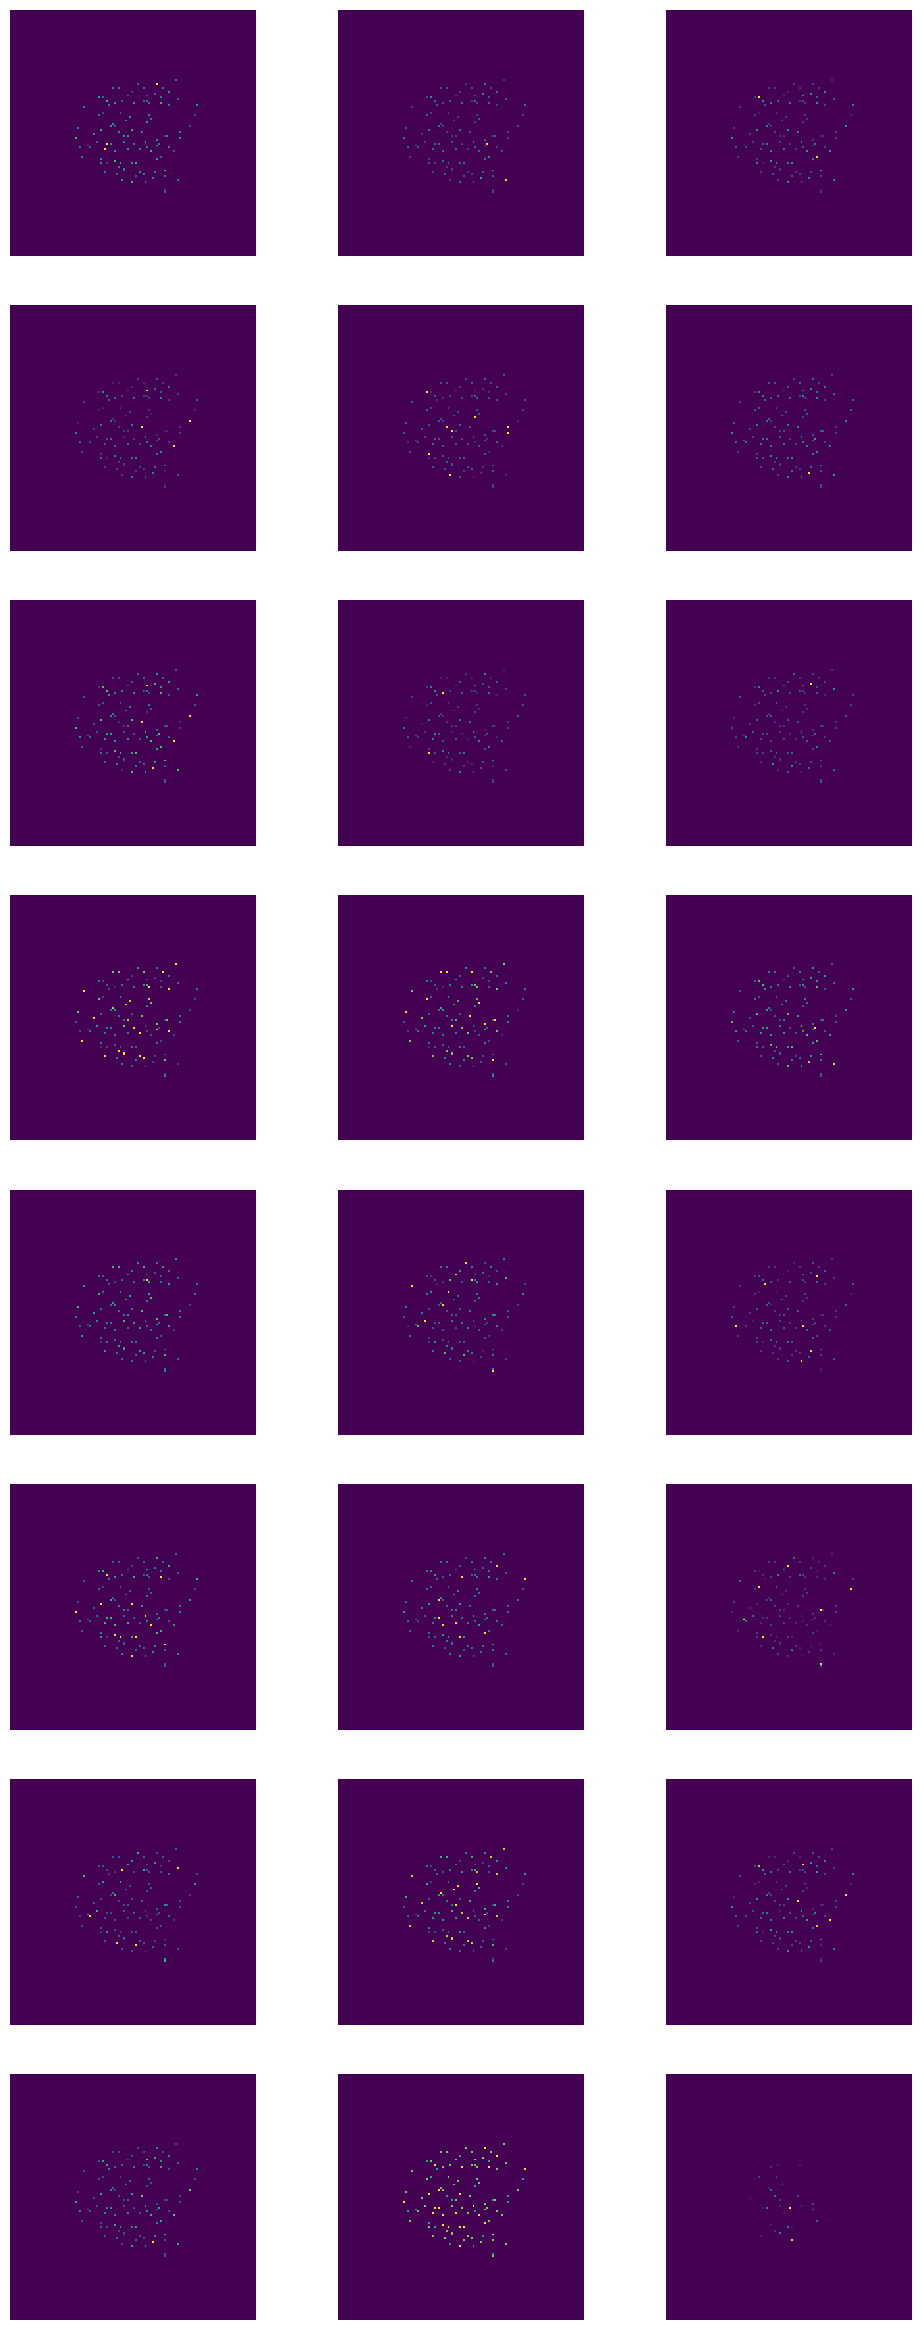

In [ ]:
images = []
for i in range(24):
    # xz 평면의 정사영 계산
    image = np.max(exmaple[..., i], axis=1)
    images.append(image)

# 이미지 시각화
fig = plt.figure(figsize=(12, 30))  # 전체 그림 크기 조정
for i in range(24):
    ax = fig.add_subplot(8, 3, i+1)
    ax.imshow(images[i], interpolation='nearest')
    plt.axis('off')  # 축 제거

plt.savefig(f'24_embedding_2.png', bbox_inches='tight', pad_inches=0)

plt.show()